# 目录
* [Introduction](#1)
* [NLP five major steps](#2)
* [Corpus](#3)
* [Tokenize](#4)
* [Stopwords](#5)
* [Bag of Words](#6)
* [Count Vectorizer](#7)
* [TF-IDF](#8)
* [Text Classification](#9)
* [Evaluation](#10)

<h2 id='1'>Introduction</h2>

- NLP :

&emsp;&emsp;The area that focuses on making machines learn and understand the textual data
in order to perform some useful tasks is known as Natural Language
Processing (NLP). 
- 应用领域：
    - chatbot
    - speech recognition
    - translation
    - spam detection
    - sentiment analysis
    - etc

<h2 id='2'>NLP five major steps</h2>

- Corpus(语料库)
- Tokenization(符号化)
- Cleaning/Stopword removal(清洗/禁用停用词
- Stemming(词干), 词干是一个词语去掉表示语法意义的词尾剩余的部分
    - 举个栗子：“老师们”,“老师”是词干,“们”是词尾
- Converting into Numerical 

<h2 id='3'> Corpus </h2>

&emsp;&emsp;语料库被 : 文本文档的集合。例如，假设在一个集合中有数千封电子邮件，我们需要处理和分析这些邮件。这组电子邮件就是语料库。

<h2 id='4'>Tokenize</h2>

&emsp;&emsp;将文本文档中给定的句子或单词集合划分为单个词汇。

In [71]:
import pandas as pd

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('nlp').getOrCreate()

df = spark.createDataFrame([(1, 'I really liked this movie'),
                                               (2, 'I would recommend this movie to my friends'),
                                               (3, 'movie was alright but acting was horrible'),
                                               (4, 'I am never watching that movie ever again')],
                                                  ['user_id', 'review'])

In [6]:
df.show(4, False)

+-------+------------------------------------------+
|user_id|review                                    |
+-------+------------------------------------------+
|1      |I really liked this movie                 |
|2      |I would recommend this movie to my friends|
|3      |movie was alright but acting was horrible |
|4      |I am never watching that movie ever again |
+-------+------------------------------------------+



In [7]:
from pyspark.ml.feature import Tokenizer

tokenization = Tokenizer(inputCol='review', outputCol='tokenized')
tokenized_df = tokenization.transform(df)
tokenized_df.show(4, False)

+-------+------------------------------------------+---------------------------------------------------+
|user_id|review                                    |tokenized                                          |
+-------+------------------------------------------+---------------------------------------------------+
|1      |I really liked this movie                 |[i, really, liked, this, movie]                    |
|2      |I would recommend this movie to my friends|[i, would, recommend, this, movie, to, my, friends]|
|3      |movie was alright but acting was horrible |[movie, was, alright, but, acting, was, horrible]  |
|4      |I am never watching that movie ever again |[i, am, never, watching, that, movie, ever, again] |
+-------+------------------------------------------+---------------------------------------------------+



<h2 id='5'>Stopwords Removal</h2>

&emsp;&emsp;为节省存储空间和提高搜索效率，在处理自然语言数据时会自动过滤掉某些字或词，这些字或词即被称为Stop Words,这些词没有什么实际含义,比如：（“the”、“a”、“an”、“that”、和“those”）

In [8]:
from pyspark.ml.feature import StopWordsRemover

sw_removal = StopWordsRemover(inputCol='tokenized', outputCol='new_tokenized')

new_df  = sw_removal.transform(tokenized_df)

new_df.select(['user_id', 'tokenized', 'new_tokenized']).show(4, False)

+-------+---------------------------------------------------+----------------------------------+
|user_id|tokenized                                          |new_tokenized                     |
+-------+---------------------------------------------------+----------------------------------+
|1      |[i, really, liked, this, movie]                    |[really, liked, movie]            |
|2      |[i, would, recommend, this, movie, to, my, friends]|[recommend, movie, friends]       |
|3      |[movie, was, alright, but, acting, was, horrible]  |[movie, alright, acting, horrible]|
|4      |[i, am, never, watching, that, movie, ever, again] |[never, watching, movie, ever]    |
+-------+---------------------------------------------------+----------------------------------+



## Converting text data into numberical vector

- Bag of Word
- Count Vector
- TF-IDF

<h2 id='6'>Bag of Words</h2>

&emsp;&emsp;BOW,不关注单词在文档中出现的顺序语义和次数，只关注词汇是否在文档中出现，是一种最简单的数值表示方法。

举个栗子：
- doc 1: The best thing in life is to travel
- doc 2: Travel is the best medicine
- doc 3: One should travel more often

词表：所有文档中词汇集合组成的列表。

doc1,2,3由13个单词组成，词表如下：

the    best    thing    in    life    is    to    travel    medicine    one    should    more    often

- doc 1 vector: 1 1 1 1 1 1 1 1 0 0 0 0 0
- doc 2 vector: 1 1 0 0 0 1 0 1 1 0 0 0 0
- doc 3 vector: 0 0 0 0 0 0 0 1 0 1 1 1 1

<h2 id='7'>Count Vectorizer</h2>

&emsp;&emsp;count vectorizer和BOW非常相似，它也不关注词的顺序和语义，但是它统计词汇在文档中出现的频次。

In [10]:
new_df.show()

+-------+--------------------+--------------------+--------------------+
|user_id|              review|           tokenized|       new_tokenized|
+-------+--------------------+--------------------+--------------------+
|      1|I really liked th...|[i, really, liked...|[really, liked, m...|
|      2|I would recommend...|[i, would, recomm...|[recommend, movie...|
|      3|movie was alright...|[movie, was, alri...|[movie, alright, ...|
|      4|I am never watchi...|[i, am, never, wa...|[never, watching,...|
+-------+--------------------+--------------------+--------------------+



In [11]:
from pyspark.ml.feature import CountVectorizer

count_vectorizer = CountVectorizer(inputCol='new_tokenized', outputCol='count_vector')

cv_df = count_vectorizer.fit(new_df).transform(new_df)

cv_df.select(['user_id', 'count_vector', 'new_tokenized']).show(4, False)

+-------+---------------------------------+----------------------------------+
|user_id|count_vector                     |new_tokenized                     |
+-------+---------------------------------+----------------------------------+
|1      |(11,[0,1,4],[1.0,1.0,1.0])       |[really, liked, movie]            |
|2      |(11,[0,3,5],[1.0,1.0,1.0])       |[recommend, movie, friends]       |
|3      |(11,[0,2,6,9],[1.0,1.0,1.0,1.0]) |[movie, alright, acting, horrible]|
|4      |(11,[0,7,8,10],[1.0,1.0,1.0,1.0])|[never, watching, movie, ever]    |
+-------+---------------------------------+----------------------------------+



### 词汇表

In [12]:
count_vectorizer.fit(new_df).vocabulary

['movie',
 'liked',
 'alright',
 'recommend',
 'friends',
 'never',
 'acting',
 'horrible',
 'really',
 'ever',
 'watching']

<h2 id='8'>TF-IDF</h2>

&emsp;&emsp;这个方法是count vector的后延,它对词频进行归一化。整个想法是，如果这个词在同一份文档中出现了很多次，那么它就会得到更多的重视，但如果它在其他文档中也均出现，这表明一个单词在整个语料库中是常见的，它的权重应该降低。

### TF : Term Frequency

- word 在文档中出现的频率

### IDF : Inverse Document Frequency

- 包含某个word文档的频率

In [14]:
from pyspark.ml.feature import HashingTF, IDF

hashing_vector = HashingTF(inputCol='new_tokenized', outputCol='tf_vector')

hashing_df = hashing_vector.transform(new_df)

hashing_df.select(['user_id', 'new_tokenized', 'tf_vector']).show(4, False)

+-------+----------------------------------+-------------------------------------------------------+
|user_id|new_tokenized                     |tf_vector                                              |
+-------+----------------------------------+-------------------------------------------------------+
|1      |[really, liked, movie]            |(262144,[14,32675,155321],[1.0,1.0,1.0])               |
|2      |[recommend, movie, friends]       |(262144,[129613,155321,222394],[1.0,1.0,1.0])          |
|3      |[movie, alright, acting, horrible]|(262144,[80824,155321,236263,240286],[1.0,1.0,1.0,1.0])|
|4      |[never, watching, movie, ever]    |(262144,[63139,155321,203802,245806],[1.0,1.0,1.0,1.0])|
+-------+----------------------------------+-------------------------------------------------------+



##### TF-IDF calculate

In [15]:
tf_idf_vector = IDF(inputCol='tf_vector', outputCol='tf_idf_vector')

tf_idf_df = tf_idf_vector.fit(hashing_df).transform(hashing_df)

tf_idf_df.select(['user_id','tf_idf_vector']).show(4, False)

+-------+----------------------------------------------------------------------------------------------------+
|user_id|tf_idf_vector                                                                                       |
+-------+----------------------------------------------------------------------------------------------------+
|1      |(262144,[14,32675,155321],[0.9162907318741551,0.9162907318741551,0.0])                              |
|2      |(262144,[129613,155321,222394],[0.9162907318741551,0.0,0.9162907318741551])                         |
|3      |(262144,[80824,155321,236263,240286],[0.9162907318741551,0.0,0.9162907318741551,0.9162907318741551])|
|4      |(262144,[63139,155321,203802,245806],[0.9162907318741551,0.0,0.9162907318741551,0.9162907318741551])|
+-------+----------------------------------------------------------------------------------------------------+



<h2 id='9'> Text Classification</h2>

- dataset : Movie Lens reviews data

In [16]:
text_df = spark.read.csv('./Data/Movie_reviews.csv', inferSchema=True, header=True, sep=',')

text_df.printSchema()

root
 |-- Review: string (nullable = true)
 |-- Sentiment: string (nullable = true)



In [17]:
text_df.count()

7087

In [18]:
# 过滤出有标记的，作为train_df

train_df = text_df.filter(((text_df.Sentiment =='1') | (text_df.Sentiment == '0')))

train_df.count()

6990

Text(0.5, 1.0, 'Label Count')

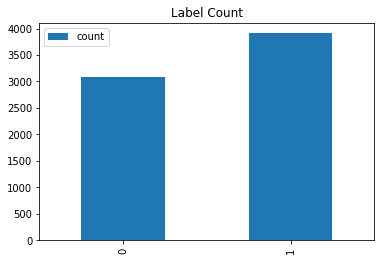

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline


label_count_df = train_df.groupBy('Sentiment').count().toPandas()

label_count_df.plot(kind='bar')

plt.title('Label Count')

In [26]:
# 随机
from pyspark.sql.functions import rand


train_df.orderBy(rand()).show(10, False)

+------------------------------------------------------------------------+---------+
|Review                                                                  |Sentiment|
+------------------------------------------------------------------------+---------+
|The Da Vinci Code is awesome!!                                          |1        |
|So Brokeback Mountain was really depressing.                            |0        |
|friday hung out with kelsie and we went and saw The Da Vinci Code SUCKED|0        |
|Always knows what I want, not guy crazy, hates Harry Potter..           |0        |
|The Da Vinci Code was awesome, I can't wait to read it...               |1        |
|Harry Potter dragged Draco Malfoy ’ s trousers down past his hips and   |0        |
|the people who are worth it know how much i love the da vinci code.     |1        |
|The Da Vinci Code is awesome..                                          |1        |
|DA VINCI CODE IS AWESOME!!                                      

In [28]:
# create a new label columns

train_df = train_df.withColumn('Label', train_df.Sentiment.cast('int')).drop('Sentiment')

train_df.orderBy(rand()).show(10, False)

+-----------------------------------------------------------------------+-----+
|Review                                                                 |Label|
+-----------------------------------------------------------------------+-----+
|Oh, and Brokeback Mountain is a TERRIBLE movie...                      |0    |
|Harry Potter dragged Draco Malfoy ’ s trousers down past his hips and  |0    |
|These Harry Potter movies really suck.                                 |0    |
|watched mission impossible 3 wif stupid haha...                        |0    |
|i love being a sentry for mission impossible and a station for bonkers.|1    |
|I love The Da Vinci Code...                                            |1    |
|I either LOVE Brokeback Mountain or think it's great that homosexuality|1    |
|Brokeback Mountain was so awesome.                                     |1    |
|dudeee i LOVED brokeback mountain!!!!                                  |1    |
|"Anyway, thats why I love "" Brokeback 

In [29]:
# add length column
from pyspark.sql .functions import length


train_df = train_df.withColumn('length', length(train_df['Review']))

train_df.orderBy(rand()).show(10, False)

+------------------------------------------------------------------------+-----+------+
|Review                                                                  |Label|length|
+------------------------------------------------------------------------+-----+------+
|""" I hate Harry Potter."                                               |0    |25    |
|I love Harry Potter.                                                    |1    |20    |
|Harry Potter is AWESOME I don't care if anyone says differently!..      |1    |66    |
|Oh, and Brokeback Mountain is a TERRIBLE movie...                       |0    |49    |
|The Da Vinci Code is awesome..                                          |1    |30    |
|Harry Potter dragged Draco Malfoy ’ s trousers down past his hips and   |0    |69    |
|, she helped me bobbypin my insanely cool hat to my head, and she laughe|0    |72    |
|I thought Brokeback Mountain was an awful movie.                        |0    |48    |
|I wanted desperately to love'Th

In [30]:
# 正负样本的平均长度


train_df.groupBy('Label').agg({'Length':'mean'}).show()

+-----+-----------------+
|Label|      avg(Length)|
+-----+-----------------+
|    1|47.61882834484523|
|    0|50.95845504706264|
+-----+-----------------+



In [33]:
# tokenization

tokenization = Tokenizer(inputCol='Review', outputCol='review_token')

train_df = tokenization.transform(train_df)

# stop_words
stop_words_removal = StopWordsRemover(inputCol='review_token', outputCol='new_token')

train_df = stop_words_removal.transform(train_df)

train_df.select(['Review', 'review_token', 'new_token']).show(10, False)

+------------------------------------------------------------------------+----------------------------------------------------------------------------------------+-------------------------------------------------------------+
|Review                                                                  |review_token                                                                            |new_token                                                    |
+------------------------------------------------------------------------+----------------------------------------------------------------------------------------+-------------------------------------------------------------+
|The Da Vinci Code book is just awesome.                                 |[the, da, vinci, code, book, is, just, awesome.]                                        |[da, vinci, code, book, awesome.]                            |
|this was the first clive cussler i've ever read, but even books like Rel|[this, was, the, first

In [37]:
# 计算过滤掉停用词后的评论长度
from pyspark.sql.functions import udf, rand, col
from pyspark.sql.types import IntegerType


token_count = udf(lambda x: len(x), IntegerType())

train_df = train_df.withColumn('token_count', token_count(col('new_token')))

train_df.select(['new_token', 'token_count']).show(10)

+--------------------+-----------+
|           new_token|token_count|
+--------------------+-----------+
|[da, vinci, code,...|          5|
|[first, clive, cu...|          9|
|[liked, da, vinci...|          5|
|[liked, da, vinci...|          5|
|[liked, da, vinci...|          8|
|[even, exaggerati...|          6|
|[loved, da, vinci...|          8|
|[thought, da, vin...|          7|
|[da, vinci, code,...|          6|
|[thought, da, vin...|          7|
+--------------------+-----------+
only showing top 10 rows



### convert text into number

- count vector
- tf
- tf-idf

In [38]:
# count vector
count_vector = CountVectorizer(inputCol='new_token', outputCol='count_vector')

train_count_vec = count_vector.fit(train_df).transform(train_df)

train_count_vec.select(['new_token', 'token_count', 'count_vector', 'label']).show(10)

+--------------------+-----------+--------------------+-----+
|           new_token|token_count|        count_vector|label|
+--------------------+-----------+--------------------+-----+
|[da, vinci, code,...|          5|(2302,[0,1,4,43,2...|    1|
|[first, clive, cu...|          9|(2302,[11,51,229,...|    1|
|[liked, da, vinci...|          5|(2302,[0,1,4,53,3...|    1|
|[liked, da, vinci...|          5|(2302,[0,1,4,53,3...|    1|
|[liked, da, vinci...|          8|(2302,[0,1,4,53,6...|    1|
|[even, exaggerati...|          6|(2302,[46,229,271...|    1|
|[loved, da, vinci...|          8|(2302,[0,1,22,30,...|    1|
|[thought, da, vin...|          7|(2302,[0,1,4,228,...|    1|
|[da, vinci, code,...|          6|(2302,[0,1,4,33,2...|    1|
|[thought, da, vin...|          7|(2302,[0,1,4,223,...|    1|
+--------------------+-----------+--------------------+-----+
only showing top 10 rows



In [40]:
# tf vector
tf_vector = HashingTF(inputCol='new_token', outputCol='tf_vector')

train_tf_vec = tf_vector.transform(train_df)

train_tf_vec.select(['new_token', 'tf_vector', 'label']).show(10)

+--------------------+--------------------+-----+
|           new_token|           tf_vector|label|
+--------------------+--------------------+-----+
|[da, vinci, code,...|(262144,[93284,11...|    1|
|[first, clive, cu...|(262144,[47372,82...|    1|
|[liked, da, vinci...|(262144,[32675,93...|    1|
|[liked, da, vinci...|(262144,[32675,93...|    1|
|[liked, da, vinci...|(262144,[5765,326...|    1|
|[even, exaggerati...|(262144,[105591,1...|    1|
|[loved, da, vinci...|(262144,[33933,11...|    1|
|[thought, da, vin...|(262144,[2000,335...|    1|
|[da, vinci, code,...|(262144,[93284,11...|    1|
|[thought, da, vin...|(262144,[23661,93...|    1|
+--------------------+--------------------+-----+
only showing top 10 rows



In [42]:
# TF-IDF
tfidf_vector = IDF(inputCol='tf_vector', outputCol='tfidf_vector')

train_tfidf_vec = tfidf_vector.fit(train_tf_vec).transform(train_tf_vec)

train_tfidf_vec.select(['new_token', 'tfidf_vector', 'label']).show(10)

+--------------------+--------------------+-----+
|           new_token|        tfidf_vector|label|
+--------------------+--------------------+-----+
|[da, vinci, code,...|(262144,[93284,11...|    1|
|[first, clive, cu...|(262144,[47372,82...|    1|
|[liked, da, vinci...|(262144,[32675,93...|    1|
|[liked, da, vinci...|(262144,[32675,93...|    1|
|[liked, da, vinci...|(262144,[5765,326...|    1|
|[even, exaggerati...|(262144,[105591,1...|    1|
|[loved, da, vinci...|(262144,[33933,11...|    1|
|[thought, da, vin...|(262144,[2000,335...|    1|
|[da, vinci, code,...|(262144,[93284,11...|    1|
|[thought, da, vin...|(262144,[23661,93...|    1|
+--------------------+--------------------+-----+
only showing top 10 rows



In [49]:
# 合并特征列

from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=['count_vector','token_count'], outputCol='X')

train_count_vec = assembler.transform(train_count_vec)

train_count_vec.select(['X', 'Label']).show(10)

+--------------------+-----+
|                   X|Label|
+--------------------+-----+
|(2303,[0,1,4,43,2...|    1|
|(2303,[11,51,229,...|    1|
|(2303,[0,1,4,53,3...|    1|
|(2303,[0,1,4,53,3...|    1|
|(2303,[0,1,4,53,6...|    1|
|(2303,[46,229,271...|    1|
|(2303,[0,1,22,30,...|    1|
|(2303,[0,1,4,228,...|    1|
|(2303,[0,1,4,33,2...|    1|
|(2303,[0,1,4,223,...|    1|
+--------------------+-----+
only showing top 10 rows



In [53]:
assembler = VectorAssembler(inputCols=['tf_vector','token_count'], outputCol='X')

train_tf_vec = assembler.transform(train_tf_vec)

train_tf_vec.select(['X', 'Label']).show(10)

+--------------------+-----+
|                   X|Label|
+--------------------+-----+
|(262145,[93284,11...|    1|
|(262145,[47372,82...|    1|
|(262145,[32675,93...|    1|
|(262145,[32675,93...|    1|
|(262145,[5765,326...|    1|
|(262145,[105591,1...|    1|
|(262145,[33933,11...|    1|
|(262145,[2000,335...|    1|
|(262145,[93284,11...|    1|
|(262145,[23661,93...|    1|
+--------------------+-----+
only showing top 10 rows



In [54]:
assembler = VectorAssembler(inputCols=['tfidf_vector', 'token_count'], outputCol='X')

train_tfidf_vec = assembler.transform(train_tfidf_vec)

train_tfidf_vec.select(['X', 'Label']).show(10)

+--------------------+-----+
|                   X|Label|
+--------------------+-----+
|(262145,[93284,11...|    1|
|(262145,[47372,82...|    1|
|(262145,[32675,93...|    1|
|(262145,[32675,93...|    1|
|(262145,[5765,326...|    1|
|(262145,[105591,1...|    1|
|(262145,[33933,11...|    1|
|(262145,[2000,335...|    1|
|(262145,[93284,11...|    1|
|(262145,[23661,93...|    1|
+--------------------+-----+
only showing top 10 rows



## LogisticRegression

对三组特征进行测试

- countvector : train_count_vec
- tf : train_tf_vec
- tf-idf : train_tfidf_vec

In [55]:
from pyspark.ml.classification import LogisticRegression

# count vector 
train_1, test_1 = train_count_vec.randomSplit([0.75, 0.25])
# tf vector
train_2, test_2 = train_tf_vec.randomSplit([0.75, 0.25])
# tf-idf vector
train_3, test_3 = train_tfidf_vec.randomSplit([0.75, 0.25])

# Training model

In [58]:
#model_1 = LogisticRegression(featuresCol='X', labelCol='Label').fit(train_1)
model_2 = LogisticRegression(featuresCol='X', labelCol='Label').fit(train_2)
model_3 = LogisticRegression(featuresCol='X', labelCol='Label').fit(train_3)

In [61]:
result_1 = model_1.evaluate(test_1).predictions
result_2 = model_2.evaluate(test_2).predictions
result_3 = model_3.evaluate(test_3).predictions

<h2 id='10'>Evaluation</h2>

- train_1 : count vector
- train_2 : tf vector
- train_3 : tfidf vector

In [75]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

accuracy_1 = MulticlassClassificationEvaluator(labelCol='Label', metricName='accuracy').evaluate(result_1)
accuracy_2 = MulticlassClassificationEvaluator(labelCol='Label', metricName='accuracy').evaluate(result_2)
accuracy_3 = MulticlassClassificationEvaluator(labelCol='Label', metricName='accuracy').evaluate(result_3)

precision_1 = MulticlassClassificationEvaluator(labelCol='Label', metricName='weightedPrecision').evaluate(result_1)
precision_2 = MulticlassClassificationEvaluator(labelCol='Label', metricName='weightedPrecision').evaluate(result_2)
precision_3 = MulticlassClassificationEvaluator(labelCol='Label', metricName='weightedPrecision').evaluate(result_3)

auc_1 = BinaryClassificationEvaluator(labelCol='Label').evaluate(result_1)
auc_2 = BinaryClassificationEvaluator(labelCol='Label').evaluate(result_2)
auc_3 = BinaryClassificationEvaluator(labelCol='Label').evaluate(result_3)

scores_df = pd.DataFrame({'feature_type':['Count_vec', 'TF_vec', 'TF-IDF_vec'],
                                             'accuracy':[accuracy_1, accuracy_2, accuracy_3],
                                             'precision':[precision_1, precision_2, precision_3],
                                             'auc':[auc_1, auc_2, auc_3]})


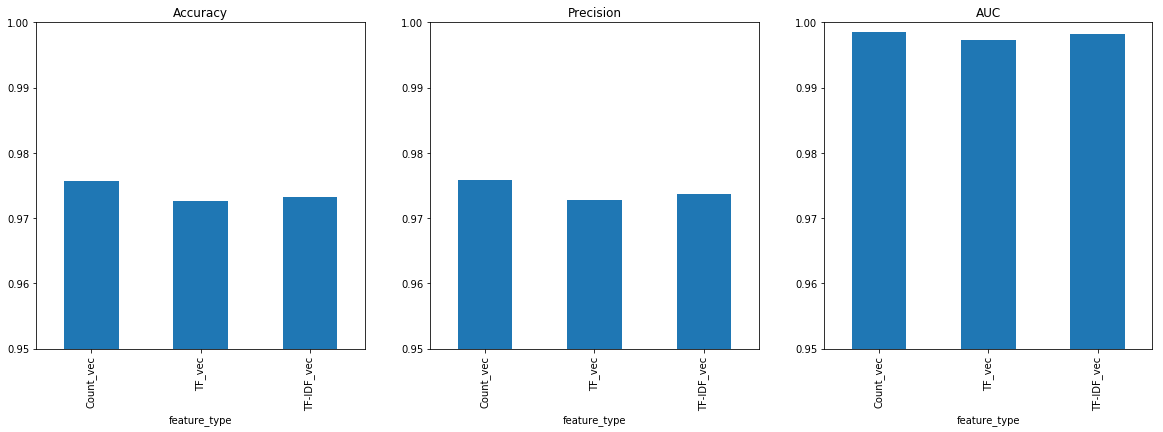

In [84]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.title('Accuracy')
plt.ylim(0.95, 1)
scores_df.set_index('feature_type').accuracy.plot(kind='bar')
plt.subplot(1, 3, 2)
plt.title('Precision')
plt.ylim(0.95, 1)
scores_df.set_index('feature_type').precision.plot(kind='bar')
plt.subplot(1, 3, 3)
plt.title('AUC')
plt.ylim(0.95, 1)
scores_df.set_index('feature_type').auc.plot(kind='bar')